<a href="https://colab.research.google.com/github/Siddhartha7340/Computer_Vision/blob/main/variational_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [ ]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

#Model building

#sampling layer

In [ ]:
class Sampling(Layer):
  def call(self,inputs):
    mean,log_var=inputs

    return mean+tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))



#Encoder

In [ ]:
encoder_inputs=Input(shape=(28,28,1))

x=Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
x=Conv2D(64,3,activation='relu',strides=2,padding='same')(x)

x=Flatten()(x)
x=Dense(16,activation='relu')(x)

mean=Dense(LATENT_DIM,)(x)
log_vari=Dense(LATENT_DIM,)(x)

z=Sampling()([mean,log_vari])

encoder_model=Model(encoder_inputs,[z,mean,log_vari],name='encoder')
encoder_model.summary()



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

#Decoder

In [ ]:
latent_inputs = Input(shape=(LATENT_DIM,))


x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

#VAE

In [ ]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vae_input (InputLayer)               │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for i in range(3):
  print(vae.layers[i])

<InputLayer name=vae_input, built=True>
<Functional name=encoder, built=True>
<Functional name=decoder, built=True>


#training

In [ ]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20

In [ ]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [ ]:
# we can also use a class by overriding the training step to use the fit method
# class VAE(tf.keras.Model):
#   def __init__(self,encoder_model,decoder_model):
#     super(VAE,self).__init__()
#     self.encoder=encoder_model
#     self.decoder=decoder_model
#     self.loss_tracker=tf.keras.metrics.Mean(name='Loss')

 @property
#   def metrics(self):
#     return [self.loss_tracker]

#   def train_step(self,x_batch):
#     with tf.GradientTape() as tape:
#       z,mean,log_var=encoder_model(x_batch)
#       y_pred=decoder_model(z)
#       y_true=x_batch
#       loss=custom_loss(y_true,y_pred,mean,log_var)

#     partial_derivatives=tape.gradient(loss,vae.trainable_weights)
#     OPTIMIZER.apply_gradients(zip(partial_derivatives,vae.trainable_weights))
#     self.loss_tracker.update_state(loss)
#     return {'loss':self.loss_tracker.result}






In [ ]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as tape:
    z,mean,log_var=encoder_model(x_batch)
    y_pred=decoder_model(z)
    y_true=x_batch
    loss=custom_loss(y_true,y_pred,mean,log_var)

  parital_derivatives=tape.gradient(loss,self.trainable_weights)
  OPTIMIZER.apply_gradients(zip(parital_derivatives,self.trainable_weights))
  return loss





In [ ]:
def learning(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step,x_batch in enumerate(train_dataset):
      loss=training_block(x_batch)
    print('\tTraining loss is %.4f' % (float(loss)))
  print('Training Complete!!!')




In [ ]:
learning(EPOCHS)

Training starts for epoch number 1
	Training loss is 191.1440
Training starts for epoch number 2
	Training loss is 188.2278
Training starts for epoch number 3
	Training loss is 178.0908
Training starts for epoch number 4
	Training loss is 179.4234
Training starts for epoch number 5
	Training loss is 171.5791
Training starts for epoch number 6
	Training loss is 179.5015
Training starts for epoch number 7
	Training loss is 176.7978
Training starts for epoch number 8
	Training loss is 167.9494
Training starts for epoch number 9
	Training loss is 169.2229
Training starts for epoch number 10
	Training loss is 169.2730
Training starts for epoch number 11
	Training loss is 166.3443
Training starts for epoch number 12
	Training loss is 169.1483
Training starts for epoch number 13
	Training loss is 164.3200
Training starts for epoch number 14
	Training loss is 162.3323
Training starts for epoch number 15
	Training loss is 153.4001
Training starts for epoch number 16
	Training loss is 154.4200
T

#testing

In [ ]:
scale=1
n=16

In [ ]:
grid_x=np.linspace(-scale,scale,16)
grid_y=np.linspace(-scale,scale,16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

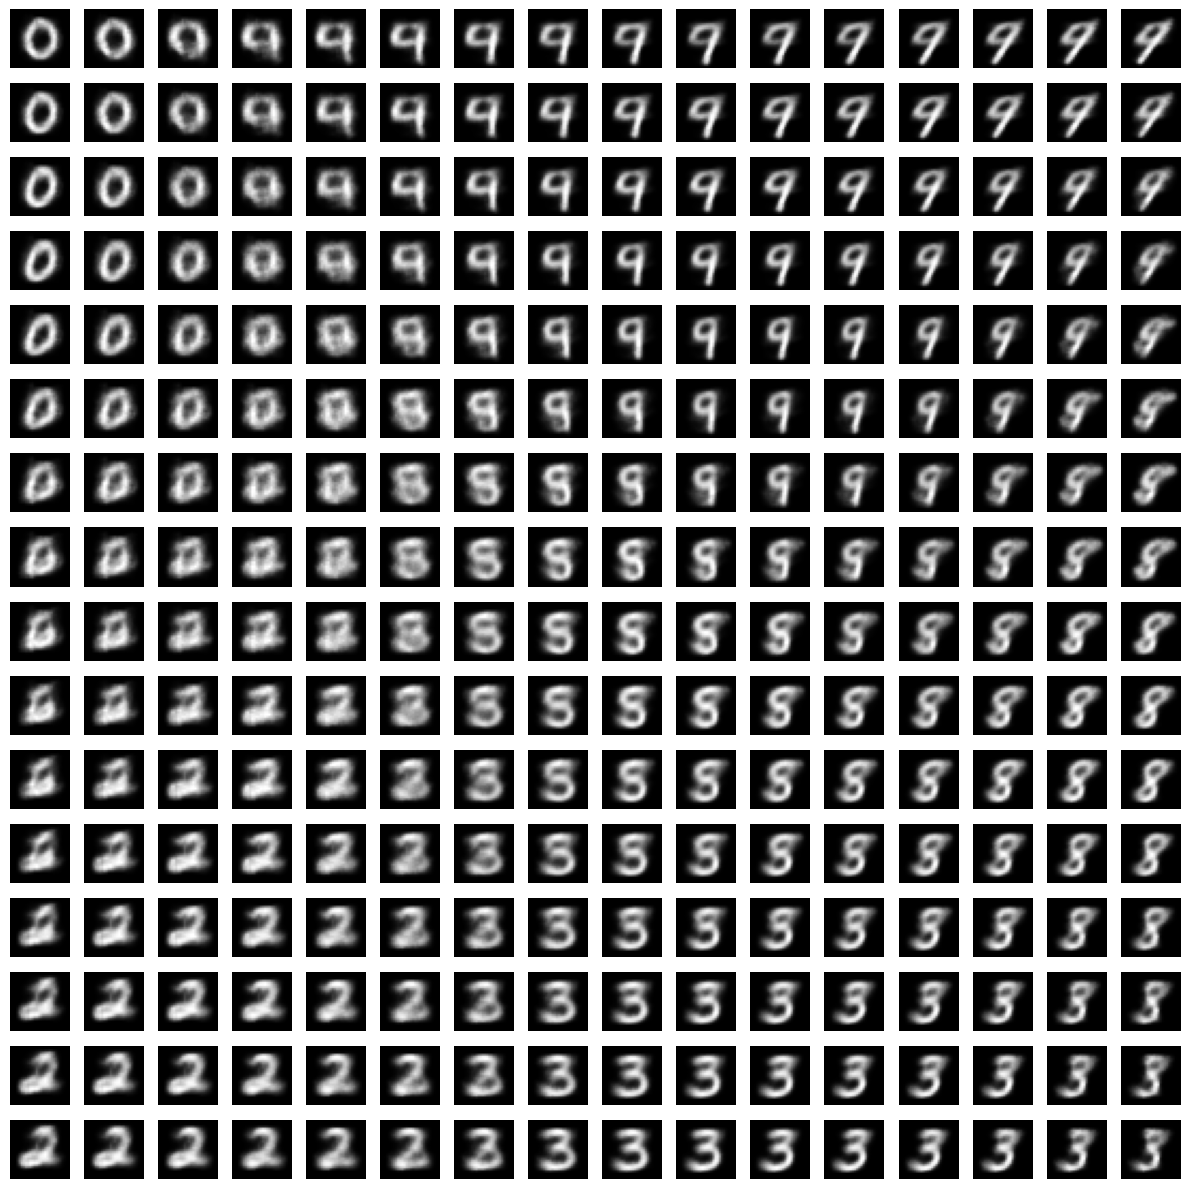

In [ ]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=vae.layers[2].predict(input)[0][...,0]
    plt.imshow(out,cmap='gray')
    plt.axis('off')
    k+=1
plt.tight_layout()
plt.show()

In [ ]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


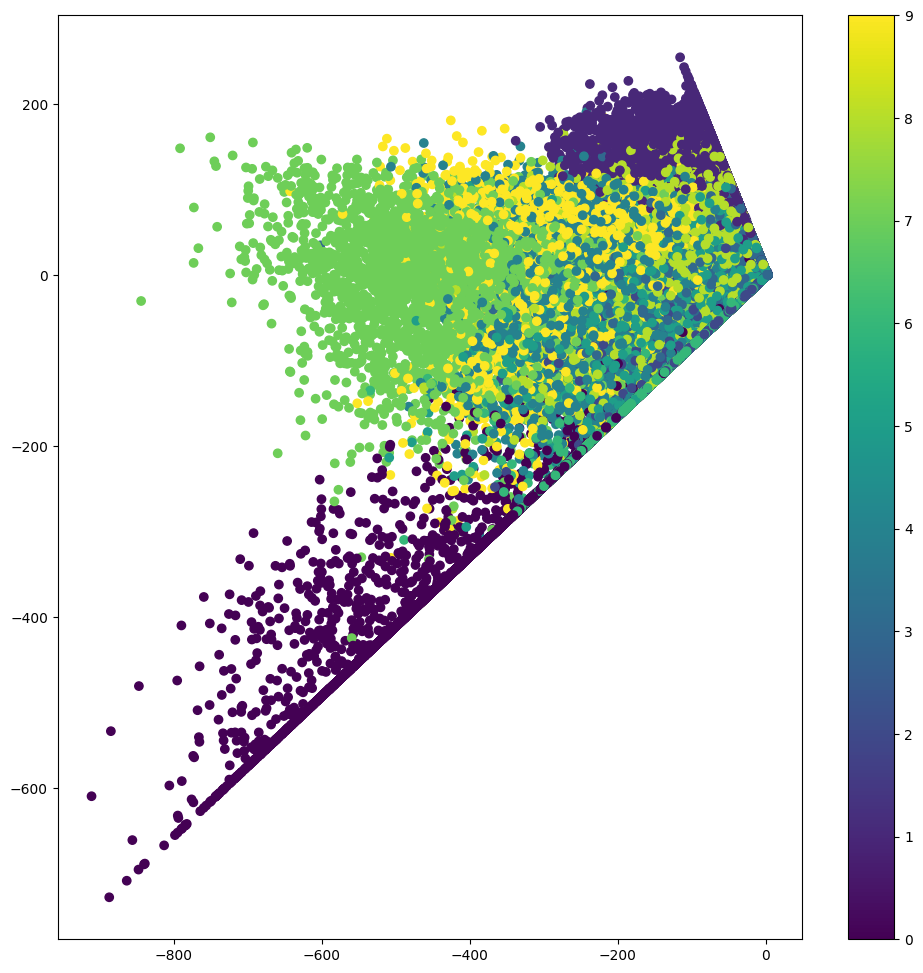

In [ ]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()